In [39]:
using EzXML
using Plots
using FFTW
using DSP
using StatsPlots
using NPZ
using Statistics

# Laser Stimulation Feature

This notebook will attempt to visualise the fluctuation of O2 and LFP readings after laser stimulation has occurred.

## Importing LFP Data

In [46]:
include("../helper/importing.jl")
lfp_data = import_lfp("Exp 2/R7/2022-05-11_17-39-17/Record Node 101/")
o2_data = import_o2("Exp 2/R7/o2 r7.txt")
lfp_data

Dict{String, Array} with 3 entries:
  "events"     => Any[Dict("activation"=>[1.0], "timestamps"=>[25998.0]), Dict(…
  "data"       => Float32[-0.266175 -0.68445 … 0.0 0.0; 0.190125 0.570375 … 0.0…
  "timestamps" => [25800.0, 25801.0, 25802.0, 25803.0, 25804.0, 25805.0, 25806.…

## Extracting Envelope of LFP Data

In [7]:
# Compute the Fourier Transform
sampling_rate = 1000
channels = [5,6,7,8]
Fs = []
for channel in channels
    push!(Fs, fft(lfp_data[channel,:]))
end
freqs = fftfreq(length(lfp_data[5,:]), sampling_rate)

# Butterworth's low pass filter equation
function butterworth_low(freq, pass_freq, n=5)
    return 1 / (1 + (abs(freq) / pass_freq) ^ 2n)
end

# Butterworth's high pass filter equation
function butterworth_high(freq, pass_freq, n=5)
    return 1 / (1 + (pass_freq / abs(freq)) ^ 2n)
end

# Apply the Band-Pass Butterworth filter
band = [10, 30]
band_pass_F = copy(F)
for i in 1:length(band_pass_F)
    band_pass_F[i] = band_pass_F[i] * butterworth_high(freqs[i], band[1]) * butterworth_low(freqs[i], band[2]) 
end

banded_lfp_data = real(ifft(band_pass_F))
lfp_envelope = abs.(hilbert(banded_lfp_data))

1601536-element Vector{Float32}:
 0.21383126
 0.21806923
 0.22221065
 0.22622913
 0.23010217
 0.23381065
 0.23733918
 0.24067585
 0.24381231
 0.24674349
 ⋮
 0.17739844
 0.18077075
 0.18442191
 0.18830411
 0.19236872
 0.19656791
 0.20085613
 0.20518902
 0.20952658

## Importing O2 Data

In [8]:
# Indexing o2_data[datapoint, time/o2/flag]

o2_path = "Exp 2/R7/"
filename = "o2 r7.txt"
o2_data = []
open("../../data/$(o2_path)$(filename)") do file
    for line in eachline(file)
        if isdigit(line[1])
            data_element = split(line, "\t")  
            if length(data_element) == 3 && data_element[3] == "#* timeTick ON "
                data_element = [parse(Float32, data_element[1]), parse(Float32, data_element[2]), 1, 0]
            elseif length(data_element) == 3 && data_element[3] == "#* heatStim ON "
                data_element = [parse(Float32, data_element[1]), parse(Float32, data_element[2]), 0, 1]
            else
                data_element = [parse(Float32, data_element[1]), parse(Float32, data_element[2]), 0, 0]
            end
            push!(o2_data, data_element)
        end
    end
end
o2_data = reduce(vcat,transpose.(o2_data))
# Normalisation
o2_data[:,2] = (o2_data[:,2] .- mean(o2_data[:,2])) ./ std(o2_data[:,2])

o2_flags = o2_data[findall(x->x==1, o2_data[:,3]), 1]
o2_laser = o2_data[findall(x->x==1, o2_data[:,4]), 1]

14-element Vector{Float32}:
  328.293
  450.314
  495.567
  535.427
  627.203
  731.83
  817.893
 1049.617
 1137.307
 1215.715
 1298.518
 1381.277
 1464.387
 1522.613

## Band-Pass Filtering O2 Data

In [9]:
# Compute the Fourier Transform
sampling_rate = 1000
F = fft(o2_data[:,2])
freqs = fftfreq(length(o2_data[:,2]), sampling_rate)

band_pass_F = copy(F)
for i in 1:length(band_pass_F)
    band_pass_F[i] = band_pass_F[i] * butterworth_high(freqs[i], band[1], 5) * butterworth_low(freqs[i], band[2], 5)
end

banded_o2_data = real(ifft(band_pass_F))

1597615-element Vector{Float32}:
  0.019915083
  0.032695264
  0.045070298
  0.056801073
  0.067666315
  0.07746879
  0.08604042
  0.09324628
  0.09898749
  0.10320251
  ⋮
 -0.07426291
 -0.06801822
 -0.060381524
 -0.05144799
 -0.041349262
 -0.030250512
 -0.018346716
 -0.005857356
  0.006979695

## Visualising Laser Stimulation Effect

### Single Event Effect

This section will plot the effect after a single laser event has occurred

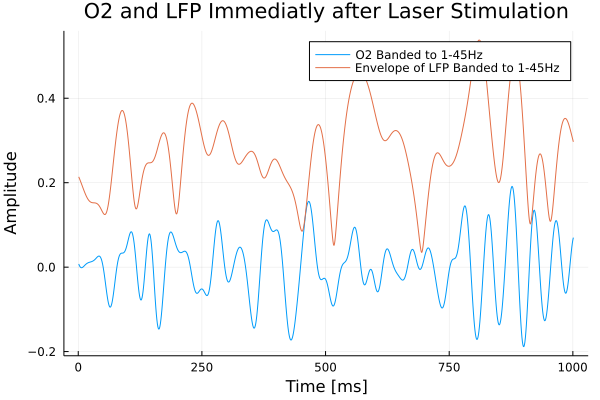

In [10]:
laser_flag = 1

o2_start = findall(x->x==o2_laser[laser_flag], o2_data[:,1])[1]
lfp_start = findall(x->x==lfp_laser[laser_flag], lfp_timestamps_extended)[1]
increment = 1000

plot(banded_o2_data[o2_start:o2_start+increment], label="O2 Banded to 1-45Hz")
plot!(lfp_envelope[lfp_start:lfp_start+increment], label="Envelope of LFP Banded to 1-45Hz")

title!("O2 and LFP Immediatly after Laser Stimulation")
xlabel!("Time [ms]")
ylabel!("Amplitude")

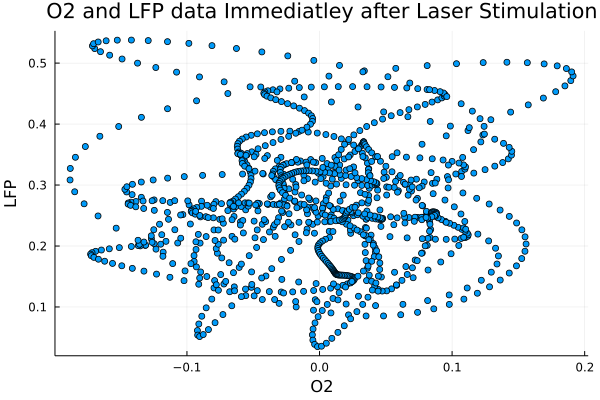

In [11]:
scatter(banded_o2_data[o2_start:o2_start+increment], lfp_envelope[lfp_start:lfp_start+increment], legend=false)
title!("O2 and LFP data Immediatley after Laser Stimulation")
xlabel!("O2")
ylabel!("LFP")

### All Events Averaged

This section will average the data immediately after each event and plot the result.

In [12]:
o2_starts = findall(x->x in o2_laser, o2_data[:,1])[1:10]
lfp_starts = findall(x->x in o2_laser, o2_data[:,1])[1:10]
increment = 1000

diffs = o2_laser[1:10] - lfp_laser[1:10]

o2_subset_mean = zeros(increment+1)
lfp_subset_mean = zeros(increment+1)

for i in o2_starts
    o2_subset_mean += (banded_o2_data[i:i+increment] .- mean(banded_o2_data[i:i+increment])) ./ var(banded_o2_data[i:i+increment])
end

for i in lfp_starts
    lfp_subset_mean += (lfp_envelope[i:i+increment] .- mean(lfp_envelope[i:i+increment])) ./ var(lfp_envelope[i:i+increment])
end

o2_subset_mean ./= length(o2_starts)
lfp_subset_mean ./= length(lfp_starts)

1001-element Vector{Float64}:
 -3.6893216013908385
 -3.7412158250808716
 -3.781369459629059
 -3.8089748501777647
 -3.823441481590271
 -3.8244529366493225
 -3.8119799137115478
 -3.7862819373607635
 -3.747859996557236
 -3.6973160803318024
  ⋮
  2.9090357422828674
  2.8796946585178373
  2.8448767602443694
  2.8040259063243864
  2.7565563321113586
  2.701886695623398
  2.639498747885227
  2.568967507779598
  2.490007172524929

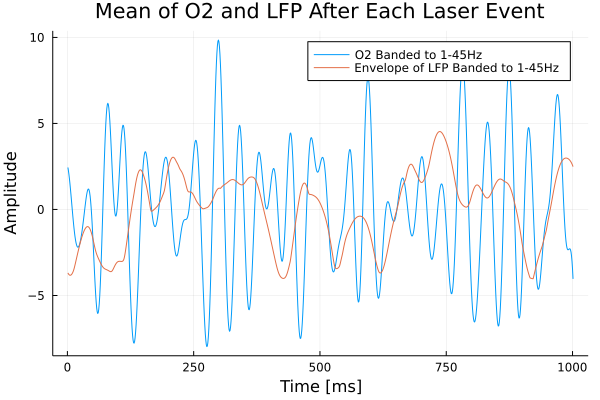

In [13]:
plot(o2_subset_mean, label="O2 Banded to 1-45Hz")
plot!(lfp_subset_mean, label="Envelope of LFP Banded to 1-45Hz")

title!("Mean of O2 and LFP After Each Laser Event")
xlabel!("Time [ms]")
ylabel!("Amplitude")

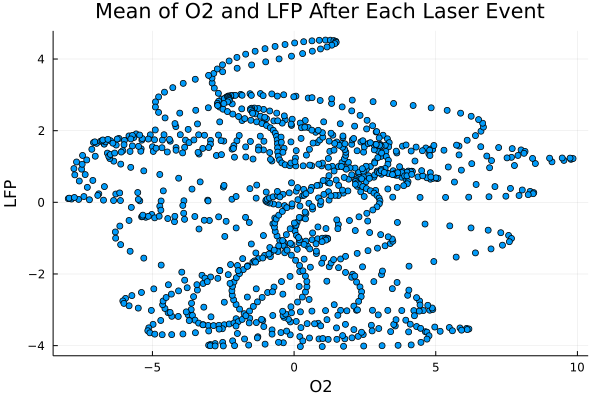

In [14]:
scatter(o2_subset_mean, lfp_subset_mean, legend=false)
title!("Mean of O2 and LFP After Each Laser Event")
xlabel!("O2")
ylabel!("LFP")